In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

from agnfinder.prospector import main, load_photometry
from agnfinder import photometry_to_table

from sklearn.covariance import GraphicalLasso, GraphicalLassoCV, MinCovDet, EmpiricalCovariance


In [3]:
DATA_ROOT='/media/mike/internal/agnfinder'

In [8]:
parquet_loc = os.path.join(DATA_ROOT, 'cpz_paper_sample_week3.parquet')

In [9]:
# len(df)

In [11]:
# df = pd.read_parquet(parquet_loc, columns=metadata_cols + unified_cols)
df = pd.read_parquet(parquet_loc)
df = df[~pd.isnull(df['redshift'])].query('redshift > 1e-2').query('redshift < 4')

In [14]:
df.columns.values

array(['id', 'alpha', 'delta', 'redshift', 'hclass', 'hquality',
       'survey_quality', 'survey_comment', 'sp_survey', 'id_sdss_u_dr12',
       'tile_name_sdss_u_dr12', 'alpha_sdss_u_dr12', 'delta_sdss_u_dr12',
       'flags_sdss_u_dr12', 'flux_radius_sdss_u_dr12', 'fwhm_sdss_u_dr12',
       'mag_auto_sdss_u_dr12', 'magerr_auto_sdss_u_dr12',
       'mag_aper2_sdss_u_dr12', 'magerr_aper2_sdss_u_dr12',
       'mag_aper3_sdss_u_dr12', 'magerr_aper3_sdss_u_dr12',
       'id_sdss_g_dr12', 'tile_name_sdss_g_dr12', 'alpha_sdss_g_dr12',
       'delta_sdss_g_dr12', 'flags_sdss_g_dr12',
       'flux_radius_sdss_g_dr12', 'fwhm_sdss_g_dr12',
       'mag_auto_sdss_g_dr12', 'magerr_auto_sdss_g_dr12',
       'mag_aper2_sdss_g_dr12', 'magerr_aper2_sdss_g_dr12',
       'mag_aper3_sdss_g_dr12', 'magerr_aper3_sdss_g_dr12',
       'id_sdss_r_dr12', 'tile_name_sdss_r_dr12', 'alpha_sdss_r_dr12',
       'delta_sdss_r_dr12', 'flags_sdss_r_dr12',
       'flux_radius_sdss_r_dr12', 'fwhm_sdss_r_dr12',
       '

In [7]:
reliable_df = photometry_to_table.get_table(df, reliable=True, errors=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-fca253af6126>", line 1, in <module>
    reliable_df = photometry_to_table.get_table(df, reliable=True, errors=True)
  File "/home/mike/repos/agnfinder/agnfinder/photometry_to_table.py", line 45, in get_table
    rows.append(load_valid_photometry_to_series(df.iloc[i], errors=errors))
  File "/home/mike/repos/agnfinder/agnfinder/photometry_to_table.py", line 24, in load_valid_photometry_to_series
    filters, maggies, maggies_unc = load_maggies_fast(galaxy, errors)
  File "/home/mike/repos/agnfinder/agnfinder/photometry_to_table.py", line 10, in load_maggies_fast
    mags = np.array(galaxy[[f.mag_col for f in valid_filters]].values).astype(float)
  File "/media/mike/Windows/linux_cache/py36/lib/python3.6/site-packages/pandas/core/series.py", line 

KeyboardInterrupt: 

In [ ]:
reliable_df.to_parquet()

In [125]:
reliable_df.head(5)

,u_sloan,g_sloan,r_sloan,i_sloan,z_sloan,VISTA_H,VISTA_J,VISTA_Ks,VISTA_Y,VISTA_Z,...,r_sloan_err,i_sloan_err,z_sloan_err,VISTA_H_err,VISTA_J_err,VISTA_Ks_err,VISTA_Y_err,VISTA_Z_err,wise_w1_err,wise_w2_err
0,1.781900e-08,5.375302e-08,7.967488e-08,1.087319e-07,1.267261e-07,1.256065e-07,1.143024e-07,1.108993e-07,1.171704e-07,1.088652e-07,...,3.482500e-09,5.042731e-09,1.892736e-08,2.295143e-08,1.997255e-08,2.598038e-08,1.338381e-08,7.425796e-09,1.164039e-08,1.600832e-08
1,1.186709e-08,6.032281e-08,1.438846e-07,2.069894e-07,2.770264e-07,2.650874e-07,1.942970e-07,2.946234e-07,2.087550e-07,1.772930e-07,...,4.999171e-09,7.183617e-09,2.496054e-08,2.496078e-08,2.655807e-08,2.936614e-08,1.514574e-08,8.077654e-09,1.842258e-08,1.991207e-08
2,2.057348e-09,1.378700e-08,6.025764e-08,1.033550e-07,1.505270e-07,2.266809e-07,1.714673e-07,2.697247e-07,1.424872e-07,1.221603e-07,...,2.893835e-09,4.281661e-09,1.457714e-08,2.362168e-08,1.877794e-08,2.431623e-08,1.236893e-08,6.861417e-09,2.163781e-08,2.203073e-08
3,2.150587e-08,6.545114e-08,1.140264e-07,1.509821e-07,1.807405e-07,1.783612e-07,1.612472e-07,1.766664e-07,1.641209e-07,1.414613e-07,...,4.300127e-09,6.152336e-09,2.335863e-08,2.471013e-08,2.116964e-08,2.910852e-08,1.519735e-08,7.991024e-09,1.405871e-08,1.727229e-08
4,4.832349e-09,2.694458e-08,9.828532e-08,1.522470e-07,2.075978e-07,3.307775e-07,2.522924e-07,3.963731e-07,2.088120e-07,1.741281e-07,...,3.164793e-09,4.598295e-09,1.514438e-08,2.628768e-08,1.887988e-08,2.776838e-08,1.408526e-08,7.601546e-09,2.459199e-08,2.395266e-08


Text(0, 0.5, 'u_sloan_err')

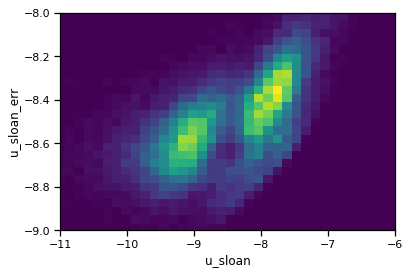

In [22]:
plt.hist2d(np.log10(reliable_df['u_sloan']), np.log10(reliable_df['u_sloan_err']), bins=[50, 50])
plt.xlim([-11, -6])
plt.ylim([-9, -8])
plt.xlabel('u_sloan')
plt.ylabel('u_sloan_err')

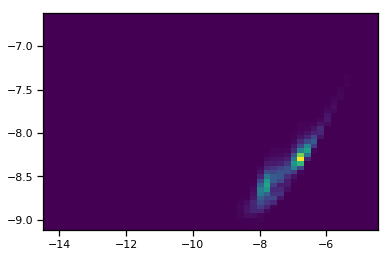

In [29]:
_ = plt.hist2d(np.log10(reliable_df['i_sloan']), np.log10(reliable_df['i_sloan_err']), bins=[50, 50])

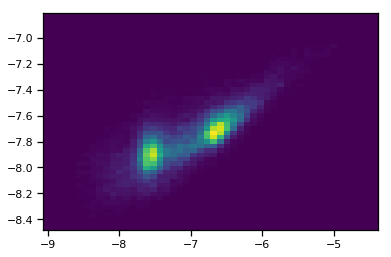

In [30]:
_ = plt.hist2d(np.log10(reliable_df['VISTA_J']), np.log10(reliable_df['VISTA_J_err']), bins=[50, 50])

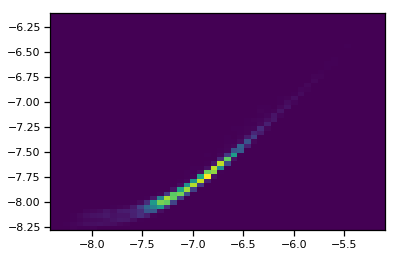

In [24]:
_ = plt.hist2d(np.log10(reliable_df['wise_w1']), np.log10(reliable_df['wise_w1_err']), bins=[50, 50])

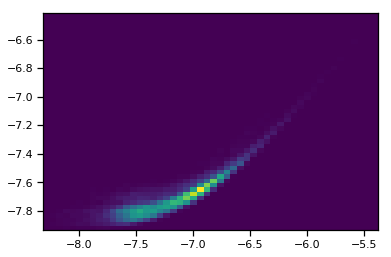

In [36]:
h, x, y, im = plt.hist2d(np.log10(reliable_df['wise_w2']), np.log10(reliable_df['wise_w2_err']), bins=[50, 50])

In [37]:
h.shape, x.shape, y.shape

((50, 50), (51,), (51,))

In [38]:
def bin_centers(x):
    return x[1:] - (x[1:] - x[:-1])/2

In [45]:
x_c = bin_centers(x)
y_c = bin_centers(y)

In [49]:
median_y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
h

array([[2., 3., 0., ..., 0., 0., 0.],
       [1., 4., 2., ..., 0., 0., 0.],
       [2., 9., 7., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 2.]])

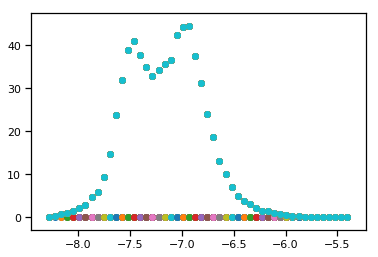

In [59]:
mean_y = np.zeros(len(y_c))
for n in range(len(y_c)):
    mean_y[n] = np.sum(y_c * h[n, :])/np.sum(y_c)
    plt.scatter(x_c, mean_y)

In [62]:
import statsmodels.api as sm

In [106]:
from scipy.interpolate import interp1d

In [63]:
lowess = sm.nonparametric.lowess

In [122]:
def log_space_fit(x, y, visualise=False):
    # x, y in real space, do fit in log space, give answers back in real space
    z = lowess(np.log10(y), np.log10(x))  # y, x format
    x_pred = z[:, 0]
    y_pred = z[:, 1]
    if visualise:
        plt.scatter(x=x_pred, y=y_pred, alpha=0.02)
    interp = interp1d(x_pred, y_pred, bounds_error=False, fill_value=np.inf)
    return lambda x: 10 ** interp(np.log10(x))

In [152]:
bands = reliable_df.columns.values[:12]
errors = reliable_df.columns.values[12:]
# 11 bands, hardcoded for now
bands, errors

(array(['u_sloan', 'g_sloan', 'r_sloan', 'i_sloan', 'z_sloan', 'VISTA_H',
        'VISTA_J', 'VISTA_Ks', 'VISTA_Y', 'VISTA_Z', 'wise_w1', 'wise_w2'],
       dtype=object),
 array(['u_sloan_err', 'g_sloan_err', 'r_sloan_err', 'i_sloan_err',
        'z_sloan_err', 'VISTA_H_err', 'VISTA_J_err', 'VISTA_Ks_err',
        'VISTA_Y_err', 'VISTA_Z_err', 'wise_w1_err', 'wise_w2_err'],
       dtype=object))

In [143]:
import dill
from tqdm import tqdm
from collections import OrderedDict

In [138]:
error_estimators = OrderedDict()
for band in tqdm(bands):
    error_estimators[band] = log_space_fit(reliable_df[band], reliable_df[band + '_err'])

In [147]:
def get_sigma(x, error_estimators):
    return np.array([error_estimators[band](x[n]) for n, band in enumerate(error_estimators.keys())])

In [168]:
with open('../data/get_sigma.pickle', 'wb') as f:
    dill.dump(get_sigma, f)

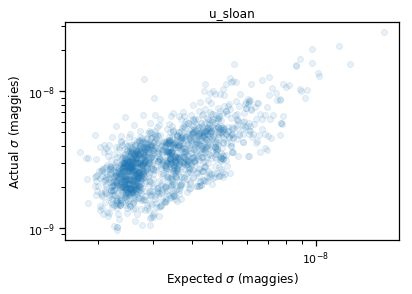

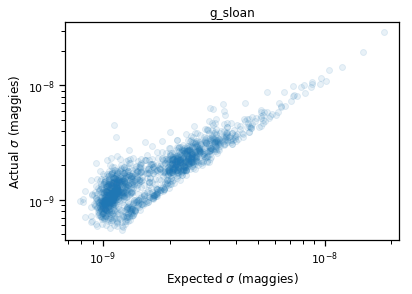

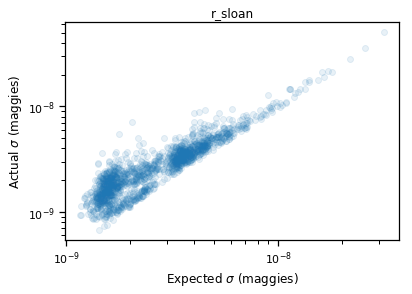

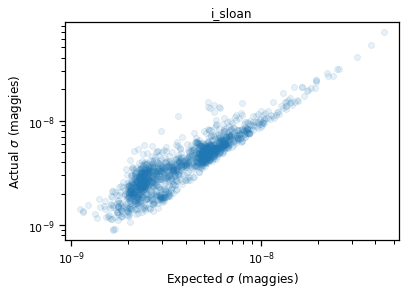

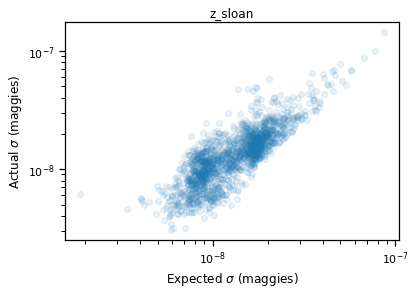

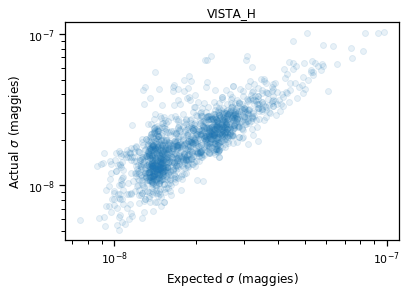

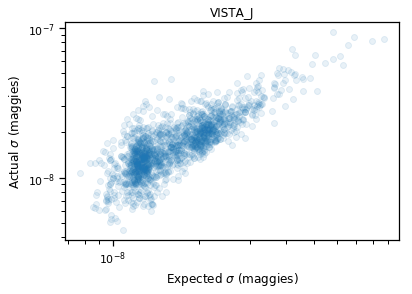

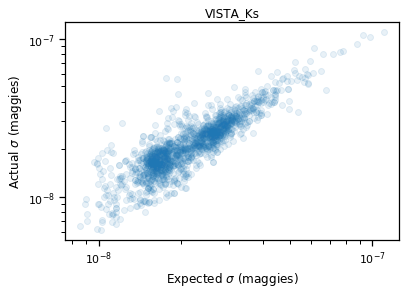

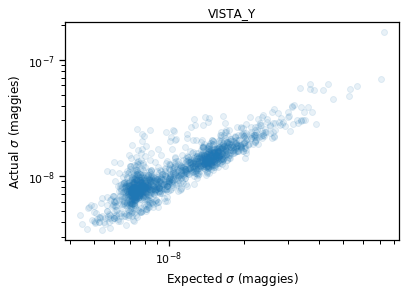

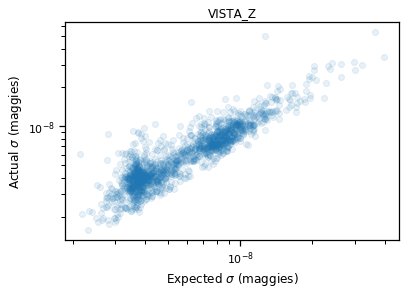

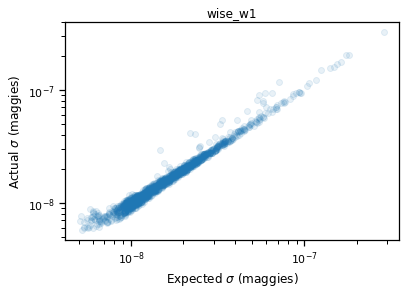

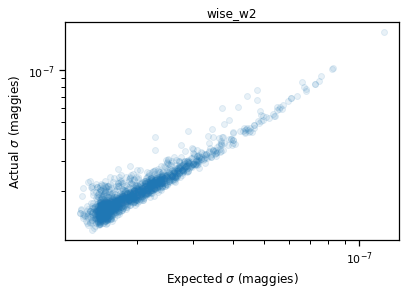

<Figure size 432x288 with 0 Axes>

In [167]:
n_galaxies = 1500
expected = np.zeros((n_galaxies, len(errors)))
actual = np.zeros((n_galaxies, len(errors)))
for n in range(n_galaxies):
    galaxy = reliable_df.sample().squeeze()
    photometry = galaxy[bands]
    expected[n] = get_sigma(photometry)
    actual[n] = galaxy[errors]
for band_n, band in enumerate(error_estimators.keys()):
    plt.loglog(expected[:, band_n], actual[:, band_n], 'o', alpha=0.1)
    plt.xlabel(r'Expected $\sigma$ (maggies)')
    plt.ylabel(r'Actual $\sigma$ (maggies)')
    plt.title(band)
    plt.figure()

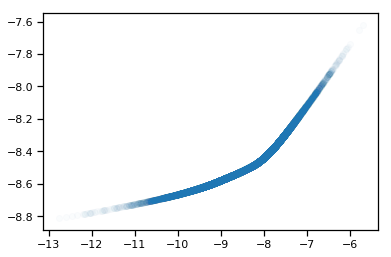

In [123]:
best_fit = log_space_fit(reliable_df['u_sloan'], reliable_df['u_sloan_err'], visualise=False)

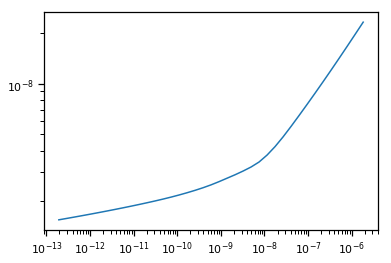

In [124]:
x = np.logspace(-14, -5)
y = best_fit(x)
plt.loglog(x, y)

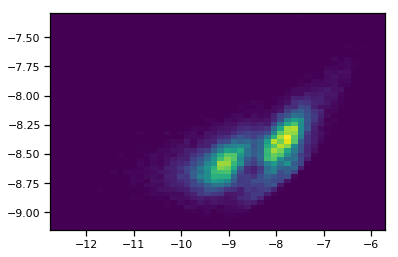

In [105]:
_ = plt.hist2d(x=np.log10(reliable_df['u_sloan']),y=np.log10(reliable_df['u_sloan_err']), bins=[50, 50])

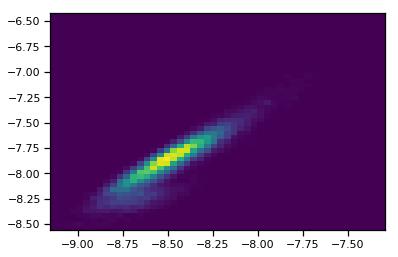

In [32]:
_ = plt.hist2d(np.log10(reliable_df['u_sloan_err']), np.log10(reliable_df['z_sloan_err']), bins=[50, 50])

Simplest thing that works: use the mean uncertainty at that magnitude

In [141]:
from agnfinder.simulation_samples import get_photometry_simulator

In [ ]:
simulator = get_photometry_simulator(emulate_ssp=False)

In [ ]:
# X = np.random.rand(18,28)
# X[12, 12] = 100
# cov = MinCovDet().fit(X)
# cov.covariance_.shape

In [ ]:
# np.around(cov.covariance_, decimals=2)

In [ ]:

from sklearn.preprocessing import normalize

In [ ]:
X = reliable_df.dropna().values
X.shape
assert not np.isnan(X).any()

In [ ]:
cov = GraphicalLassoCV(max_iter=1000, cv=5).fit(X)
# cov = EmpiricalCovariance().fit(X)
# np.around(cov.covariance_, decimals=3)

In [ ]:
labelled_cov = pd.DataFrame(cov.covariance_, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_cov, ax=ax)

In [ ]:
inv_cov = np.linalg.inv(cov.covariance_)

In [ ]:
labelled_cov = pd.DataFrame(inv_cov, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_cov, ax=ax)

In [ ]:
log_X = np.log10(X)
# X = normalize(np.log10(X))

In [ ]:
log_cov = GraphicalLassoCV(max_iter=10000, cv=5).fit(log_X)

In [ ]:
labelled_log_cov = pd.DataFrame(log_cov.covariance_, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_log_cov, ax=ax)

In [ ]:
inv_log_cov = np.linalg.inv(log_cov.covariance_)

In [ ]:
np.around(inv_log_cov, decimals=3)

In [ ]:
labelled_log_cov = pd.DataFrame(inv_log_cov, index=reliable_df.columns.values, columns=reliable_df.columns.values)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(labelled_log_cov, ax=ax)

In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
log_norm = multivariate_normal(mean=None, cov=log_cov.covariance_)
norm = multivariate_normal(mean=None, cov=cov.covariance_)

In [ ]:
fig, ax = plt.subplots()
for i in range(100):
    ax.scatter(range(12), norm.rvs(), alpha=0.2)

In [ ]:
plt.loglog(range(12), np.abs(norm.rvs()), 'x')
# plt.ylim([-2., 2.])

In [ ]:
np.log10(np.abs(norm.rvs()))

In [ ]:
plt.scatter(range(12), log_norm.rvs())
plt.ylim([-2., 2.])